In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import pandas
import warnings

warnings.filterwarnings('ignore')

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
class OptionPriceSimulator:
    def __init__(
            self,
            number_of_underlying: int,
            risk_free_rate=0.02,
            seed=42,
            interval=500,
            time_period=1,
            **kwargs
    ):
        self._seed = seed
        self._time_period = time_period
        self._interval = interval
        self._risk_free_rate = risk_free_rate
        self.number_of_underlying = number_of_underlying
        ...

    def covariance_matrix(self, dim=0):
        if not dim:
            dim = self.number_of_underlying
        torch.manual_seed(self._seed)
        A = torch.randn(dim, dim)
        cov_matrix = A @ A.T
        cov_matrix += torch.eye(dim) * 1e-3
        return cov_matrix.to(DEVICE)

    def correlation_matrix(self, dim=0):
        if not dim:
            dim = self.number_of_underlying
        cov_matrix = self.covariance_matrix(dim=dim)
        std = torch.sqrt(torch.diag(cov_matrix))
        std_outer = torch.outer(std, std)
        std_outer = torch.where(std_outer == 0, torch.ones_like(std_outer), std_outer)
        corr_matrix = cov_matrix / std_outer
        return corr_matrix.to(DEVICE)

    def initial_proportion(self):
        torch.manual_seed(self._seed)
        prop = torch.distributions.Uniform(0, 1).sample(sample_shape=(self.number_of_underlying, 1)).to(DEVICE)
        return torch.softmax(prop, dim=0)

    def random_logreturn(self):
        torch.manual_seed(self._seed)
        brownian_motion = torch.distributions.Normal(0, self._time_period/self._interval).sample(sample_shape=(self.number_of_underlying, self._interval)).to(DEVICE)
        return self._risk_free_rate * torch.ones((self.number_of_underlying, 1), device=DEVICE) * self._time_period / self._interval + self.covariance_matrix() @ brownian_motion

    @property
    def underlying_prices(self):
        nv = torch.ones(size=(self.number_of_underlying, 1 + self._interval), device=DEVICE)
        for i in range(self._interval):
            nv[:, i + 1] = nv[:, i] * torch.exp(self.random_logreturn()[:, i])
        return nv

    @property
    def index_price(self):
        return self.underlying_prices.T @ self.initial_proportion()

    def index_price_plot(self):
        _, ax = plt.subplots(1, 1, figsize=(10, 4))
        x_axis = [x * self._time_period / self._interval for x in range(self._interval + 1)]
        ax.plot(x_axis, self.index_price.cpu(), label='Index Price', linewidth=3)
        for i, comp in enumerate(self.underlying_prices):
            ax.plot(x_axis, comp.cpu(), label=f'Underlying {i + 1} Price', linestyle='--')
        ax.set_xlabel('Time (in years)')
        ax.set_ylabel('Index Price')
        ax.set_title('Index Price Simulation')
        ax.grid("both")
        ax.legend()
        plt.show()


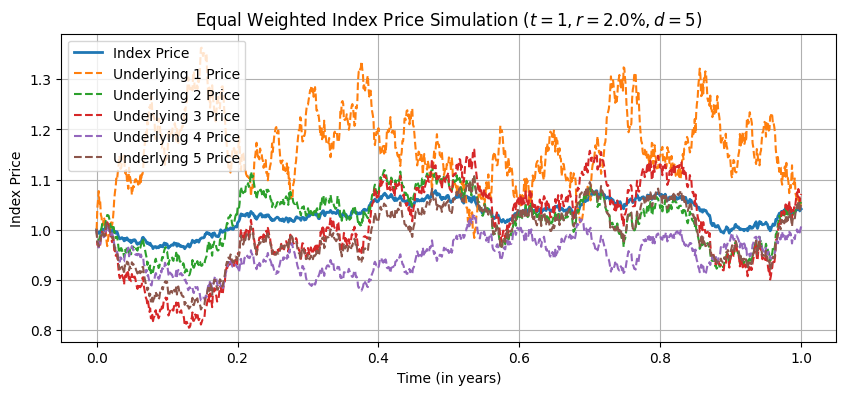

In [25]:
Dataset = OptionPriceSimulator(5, time_period=1, interval=1000)
Dataset.index_price_plot()

In [4]:
def monte_carlo_option_pricing(S, cov, t, r, payoff, strike, simulations=100000):
    """
    Monte Carlo option pricing using only PyTorch.

    Parameters:
    S: torch.Tensor
       Current price vector of high-dimensional assets (shape: (d,))
    cov: torch.Tensor
         Covariance matrix among assets (shape: (d, d))
    t: float
       Time to maturity (in years)
    r: float
       Risk-free interest rate
    payoff: function
            Payoff function at maturity. It accepts an asset price matrix of shape (simulations, d)
            and returns a tensor of payoff values (shape: (simulations,))
    simulations: int
                 Number of simulation paths

    Returns:
    torch.Tensor
        The current theoretical price of the option (a scalar)
    """
    dim = S.shape[0]  # Number of assets
    t = torch.tensor(t)
    r = torch.tensor(r)

    L = torch.linalg.cholesky(cov)

    diffusion = (torch.randn(simulations, dim).to(DEVICE) * torch.sqrt(t)) @ L

    drift = (r - torch.diag(cov) / 2) * t

    S_t = S * torch.exp(drift + diffusion)

    prices = torch.Tensor([payoff(s, strike) for s in S_t])

    return prices.mean() * torch.exp(-r * t)


In [5]:
def black_scholes_call(S, K, T, r, sigma):
    """
    Calculates the Black-Scholes price for a European call option using PyTorch.

    Parameters:
    S : float or torch.Tensor
        Current underlying asset price.
    K : float or torch.Tensor
        Strike price.
    T : float or torch.Tensor
        Time to maturity (in years).
    r : float or torch.Tensor
        Risk-free interest rate.
    sigma : float or torch.Tensor
        Volatility of the underlying asset.

    Returns:
    torch.Tensor
        The Black-Scholes call option price.
    """
    # Convert inputs to torch tensors with a consistent data type
    S = torch.tensor(S, dtype=torch.float64)
    K = torch.tensor(K, dtype=torch.float64)
    T = torch.tensor(T, dtype=torch.float64)
    r = torch.tensor(r, dtype=torch.float64)
    sigma = torch.tensor(sigma, dtype=torch.float64)

    # Compute d1 and d2 as per the Black-Scholes formula:
    # d1 = (ln(S/K) + (r + 0.5*sigma^2)*T) / (sigma*sqrt(T))
    # d2 = d1 - sigma*sqrt(T)
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * torch.sqrt(T))
    d2 = d1 - sigma * torch.sqrt(T)

    # Standard normal cumulative distribution function
    normal = torch.distributions.Normal(0, 1)

    # Black-Scholes call option price:
    # call = S * N(d1) - K * exp(-r*T) * N(d2)
    call_price = S * normal.cdf(d1) - K * torch.exp(-r * T) * normal.cdf(d2)
    return call_price.item()

# Deep Learning Techniques

Define our payoff function
$$g(S_T) = \max(\frac{1}{N}\sum_{i=1}^{N}S_T^i - K, 0)$$

i.e. it is an arithmetic average vanilla call option.

If $N=1$, then it is a vanilla call.

In [380]:
def payoff_function(price: torch.Tensor, strike: torch.Tensor) -> torch.Tensor:
    return torch.clamp(price.max() - strike, min=0)

## Network Foundational Structure

### Single Net Version

In [87]:
class BSDE_Net(nn.Module):
    def __init__(self, asset_dim, hidden_dim):
        super(BSDE_Net, self).__init__()
        self.input_dim = asset_dim + 1
        self.hidden_dim = hidden_dim
        self.output_dim = self.input_dim
        self.net: nn.Sequential | None = None

    def param_num(self):
        return sum(
            [p.numel() for p in self.net.parameters()]
        )

    def forward(self, time: torch.Tensor, price: torch.Tensor) -> torch.Tensor:
        assert isinstance(time, torch.Tensor) and isinstance(price, torch.Tensor)
        if time.dim() == 1:
            time = time.unsqueeze(0).requires_grad_(True)
        if price.dim() == 1:
            price = price.unsqueeze(0).requires_grad_(True)
        Input = torch.cat([time, price], dim=1)
        return self.net(Input)


def Route_generate(batch_size, S0: torch.Tensor, cov: torch.Tensor, t_grid: torch.Tensor, r: torch.Tensor):
    std = torch.linalg.cholesky(cov)
    dt = (t_grid.max() - t_grid.min()) / (len(t_grid) - 1)
    dWt = torch.randn(batch_size, len(t_grid) - 1, S0.shape[0], device=DEVICE) * torch.sqrt(dt)
    S = torch.zeros(batch_size, len(t_grid), S0.shape[0], device=DEVICE)
    S[:, 0, :] = S0.unsqueeze(0).repeat(batch_size, 1)
    for t_ in range(len(t_grid) - 1):
        S[:, t_ + 1, :] = S[:, t_, :] * (1 + r * dt + ( dWt[:, t_, :]) @ std )
    return t_grid, dWt, S


def Loss_BSDE(networks: BSDE_Net, S: torch.Tensor, t_grid: torch.Tensor, dW: torch.Tensor, r: torch.Tensor) -> torch.Tensor:
    loss = 0
    dt = (t_grid.max() - t_grid.min()) / (len(t_grid) - 1)
    Y_pred = networks(t_grid[0].repeat(S.shape[0], 1), S[:, 0, :]).squeeze()

    for i_ in range(len(t_grid) - 1):
        t_i = t_grid[i_] * torch.ones((S.shape[0], 1), device=DEVICE)
        S_i = S[:, i_, :]

        result = networks(t_i, S_i)
        Y_i = result[:, 0].squeeze()
        Z_i = result[:, 1:]

        t_next = t_grid[i_ + 1] * torch.ones((S.shape[0], 1), device=DEVICE)
        Y_next = Y_i - r * Y_i * dt + torch.sum(Z_i * dW[:, i_ ,:], dim=1)
        Y_pred = networks(t_next, S[:, i_ + 1, :])[:, 0]
        loss += torch.sum((Y_next - Y_pred) ** 2)
    return loss


def Loss_PINN(networks: BSDE_Net, S: torch.Tensor, t_grid: torch.Tensor, cov: torch.Tensor, r: torch.Tensor) -> torch.Tensor:
    loss = 0
    for i_ in range(len(t_grid)):
        for batch in range(S.shape[0]):
            t_i = t_grid[i_] * torch.ones(1, device=DEVICE).requires_grad_(True)
            S_i = S[batch, i_, :].requires_grad_(True)

            result = networks(t_i, S_i)
            Y_i = result[:, 0]
            dV_dt = torch.autograd.grad(Y_i, t_i, create_graph=True)[0]
            dV_dS = torch.autograd.grad(Y_i, S_i, create_graph=True)[0]
            d2V_dS2 = torch.concat([torch.autograd.grad(d, S_i, create_graph=True)[0].unsqueeze(0) for d in dV_dS], dim=0)
            S2 = S_i.reshape(-1, 1) @ S_i.reshape(1, -1)
            loss += (dV_dt + r * (dV_dS * S_i).sum() + (S2 * cov * d2V_dS2).sum() / 2 - r * Y_i) ** 2
    return loss[0]


def Loss_Terminal(networks: BSDE_Net, S: torch.Tensor, t_grid: torch.Tensor, payoff, strike: torch.Tensor) -> torch.Tensor:
    Y_T = networks(t_grid[-1] * torch.ones((S.shape[0], 1), device=DEVICE), S[:, -1, :])[:, 0].squeeze()
    return torch.sum((Y_T - payoff(S[:, -1, :], strike)) ** 2)


def Nets_Training(
        networks: BSDE_Net,
        S0: torch.Tensor,
        t: torch.Tensor,
        cov: torch.Tensor,
        r: torch.Tensor,
        payoff,
        strike: torch.Tensor,
        num_time_steps: int, batch_size: int=64, epochs: int=10000,
        **kwargs
) -> dict[str: list]:

    dim = S0.shape[0]
    input_dim = 1 + dim
    assert networks.input_dim == input_dim == networks.output_dim
    assert S0.dim() == 1
    dt = t / num_time_steps
    t_grid = torch.linspace(t, 0, num_time_steps + 1, device=DEVICE)

    S0 = S0.to(DEVICE)
    std = torch.linalg.cholesky(cov)


    lr = kwargs.get("lr", 0.001)
    optimizer = optim.Adam(networks.net.parameters(), lr=lr)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

    Loss_List_Total = []
    Loss_List_BSDE = []
    Loss_List_Terminal = []
    Loss_List_PINN = []
    Price_Prediction = []

    for epoch in range(epochs):

        S = torch.zeros(batch_size, num_time_steps+1, dim, device=DEVICE)
        S[:, 0, :] = S0.unsqueeze(0).repeat(batch_size, 1)
        # 生成 Brownian 增量，形状 (batch_size, num_time_steps, d)
        dW = torch.randn(batch_size, num_time_steps, dim, device=DEVICE) * torch.sqrt(torch.tensor(dt, device=DEVICE))

        # 使用 Euler-Maruyama 法模拟状态过程
        for i in range(num_time_steps):
            S[:, i+1, :] = S[:, i, :] * (1 + r * dt + dW[:, i, :] @ std)

        # 利用网络预测 BSDE 的解，并构造 BSDE 残差
        loss_bsde = 0.0
        # 在时间 t=0 处，Y_net 的预测作为初始值
        # Y_pred = networks(t_grid[0].repeat(batch_size), S[:, 0, :]).squeeze()  # shape (batch_size,)
        # Y_current = Y_pred  # 初始化 BSDE 递推的 Y
        for i in range(num_time_steps):
            t_i = t_grid[i].repeat(batch_size, 1)
            X_i = S[:, i, :]

            # print(t_i.dim(), X_i.dim(), torch.concat([t_i, X_i], dim=1))
            # 网络预测当前时刻 Y 和 Z
            Y_i = networks(t_i, X_i)[:, 0]            # (batch_size,)
            Z_i = networks(t_i, X_i)[:, 1:]                        # (batch_size, d)
            # BSDE 驱动函数 f = r * Y（风险中性下）
            f_i = r * Y_i
            # BSDE Euler 递推：Y_hat = Y_i - f_i*dt + <Z_i, dW_i>
            dW_i = dW[:, i, :]  # (batch_size, d)
            Y_hat = Y_i - f_i * dt + torch.sum(Z_i * dW_i, dim=1)
            # 网络在下一个时间点的预测
            t_next = t_grid[i+1].repeat(batch_size, 1)
            Y_next = networks(t_next, S[:, i+1, :])[:, 0]
            # 累加 BSDE 动态的一致性误差
            loss_bsde = loss_bsde + torch.mean((Y_hat - Y_next)**2)


        # 终端条件损失：Y_net(T, X_T) 应当等于支付函数 g(X_T)
        t_T = t_grid[-1].repeat(batch_size, 1)
        Y_T = networks(t_T, S[:, -1, :])[:, 0]
        loss_terminal = torch.mean((Y_T - payoff(S[:, -1, :], strike))**2)

        # _, dW, S_ = Route_generate(batch_size, S0, cov, t_grid, r)

        # loss_pinn = Loss_PINN(networks, S_, t_grid, cov, r)
        loss_pinn = torch.tensor(0, device=DEVICE)
        # loss_bsde = Loss_BSDE(networks, S_, t_grid, dW, r)
        # loss_terminal = Loss_Terminal(networks, S_, t_grid, payoff, strike)

        loss = 10 * loss_bsde + 0.1 * loss_terminal + loss_pinn
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()


        with torch.no_grad():
            Loss_List_Total.append(loss.item())
            Loss_List_BSDE.append(loss_bsde.item())
            Loss_List_Terminal.append(loss_terminal.item())
            Loss_List_PINN.append(loss_pinn.item())
            time = torch.tensor([[4/4], [3/4], [2/4], [1/4], [0/4]]).to(DEVICE) * t
            price_pred = networks(time, torch.ones(5, 1).to(DEVICE) * S0)[:, 0]
            Price_Prediction.append(price_pred)
            if (1 + epoch) % 100 == 0 or epoch == 0 or epoch:
                print(f"Epoch: {epoch + 1}/{epochs}, "
                  f"Total Loss: {loss:.4f}, "
                  f"BSDE Loss: {loss_bsde * 10:.4f}, "
                  f"Terminal Loss: {loss_terminal * 0.1:.4f}, "
                  f"PINN Loss: {loss_pinn:.4f}, " + ", ".join([f"Y({t_.item():.2f}, S0): {price_pred[i]:.4f}" for i, t_ in enumerate(time)]))

    return {"epochs": [epoch + 1 for epoch in range(epochs)], "loss_total": Loss_List_Total, "loss_bsde": Loss_List_BSDE, "loss_terminal": Loss_List_Terminal, "price_prediction": Price_Prediction}

### Two Nets Version

In [399]:
class YNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(YNet, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = 1
        self.net: nn.Sequential | None = None

    def forward(self, time: torch.Tensor, price: torch.Tensor) -> torch.Tensor:
        assert isinstance(time, torch.Tensor) and isinstance(price, torch.Tensor)
        if time.dim() == 1:
            time = time.unsqueeze(1)
        Input = torch.cat([time, price], dim=1)
        return self.net(Input)


class ZNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ZNet, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.net: nn.Sequential | None = None

    def forward(self, time: torch.Tensor, price: torch.Tensor) -> torch.Tensor:
        assert isinstance(time, torch.Tensor) and isinstance(price, torch.Tensor)
        if time.dim() == 1:
            time = time.unsqueeze(1)
        Input = torch.cat([time, price], dim=1)
        return self.net(Input)


class BSDE_Net(nn.Module):
    def __init__(self, asset_dim, hidden_dim):
        super(BSDE_Net, self).__init__()
        self.YNet = YNet(asset_dim + 1, hidden_dim)
        self.ZNet = ZNet(asset_dim + 1, hidden_dim, asset_dim)

    def param_num(self):
        return sum(
            [p.numel() for p in self.YNet.parameters()] + [p.numel() for p in self.ZNet.parameters()]
        )


def Route_generate(batch_size, S0: torch.Tensor, cov: torch.Tensor, t_grid: torch.Tensor, r: torch.Tensor):
    std = torch.linalg.cholesky(cov)
    dt = (t_grid.max() - t_grid.min()) / (len(t_grid) - 1)
    dWt = torch.randn(batch_size, len(t_grid) - 1, S0.shape[0], device=DEVICE) * torch.sqrt(dt)
    S = torch.zeros(batch_size, len(t_grid), S0.shape[0], device=DEVICE)
    S[:, 0, :] = S0.unsqueeze(0).repeat(batch_size, 1)
    for t_ in range(len(t_grid) - 1):
        S[:, t_ + 1, :] = S[:, t_, :] * (1 + r * dt + (dWt[:, t_, :] @ std))
    return t_grid, dWt, S


def Loss_BSDE(networks: BSDE_Net, S: torch.Tensor, t_grid: torch.Tensor, dW: torch.Tensor, r: torch.Tensor) -> torch.Tensor:
    loss = 0
    dt = (t_grid.max() - t_grid.min()) / (len(t_grid) - 1)
    y_net, z_net = networks.YNet, networks.ZNet
    for i_ in range(len(t_grid) - 1):
        t_i = t_grid[i_].repeat(S.shape[0])
        S_i = S[:, i_, :]

        Y_i = y_net(t_i, S_i).squeeze()
        Z_i = z_net(t_i, S_i)

        t_next = t_grid[i_ + 1].repeat(S.shape[0])
        Y_next = Y_i - r * Y_i * dt + torch.sum(Z_i * dW[:, i_ ,:], dim=1)  # torch.sum(Z_i * dW[:, i_ ,:], dim=1)Z_i.T @ dW[:, i_, :]
        Y_pred = y_net(t_next, S[:, i_ + 1, :]).squeeze()
        loss += torch.sum((Y_next - Y_pred) ** 2)
    return loss


def Loss_PINN(networks: BSDE_Net, S: torch.Tensor, t_grid: torch.Tensor, cov: torch.Tensor, r: torch.Tensor) -> torch.Tensor:
    loss = 0
    for i_ in range(len(t_grid)):
        loss_batch = []
        for batch in range(S.shape[0]):
            t_i = t_grid[i_].repeat(S.shape[2]).requires_grad_(True)
            S_i = S[batch, i_, :].reshape(1, -1).requires_grad_(True)

            Y_i = networks.YNet(t_i, S_i)
            Z_i = networks.ZNet(t_i, S_i)
            dV_dt = torch.autograd.grad(Y_i, t_i, create_graph=True)[0]
            dV_dS = Z_i
            d2V_dS2 = torch.concat([torch.autograd.grad(d, S_i, create_graph=True)[0].unsqueeze(0) for d in dV_dS], dim=0)
            loss_batch.append((dV_dt + r * (dV_dS * S_i).sum() + (cov * d2V_dS2).sum() / 2 + Y_i) ** 2)
        loss += torch.mean(torch.Tensor(loss_batch))
    return loss


def Loss_Terminal(networks: BSDE_Net, S: torch.Tensor, t_grid: torch.Tensor, payoff, strike: torch.Tensor) -> torch.Tensor:
    Y_T = networks.YNet(t_grid[-1].repeat(S.shape[0]), S[:, -1, :]).squeeze()
    return torch.sum((Y_T - payoff(S[:, -1, :], strike)) ** 2)


def Nets_Training(
        networks: BSDE_Net,
        S0: torch.Tensor,
        t: torch.Tensor,
        cov: torch.Tensor,
        r: torch.Tensor,
        payoff,
        strike: torch.Tensor,
        num_time_steps: int, batch_size: int=64, epochs: int=10000,
        **kwargs
) -> dict[str: list]:

    assert S0.dim() == 1
    dim = S0.shape[0]
    dt = t / num_time_steps
    std = torch.linalg.cholesky(cov)
    t_grid = torch.linspace(t, 0, num_time_steps + 1, device=DEVICE)

    S0 = S0.to(DEVICE)

    input_dim = 1 + dim
    assert networks.YNet.input_dim == input_dim == networks.ZNet.input_dim

    lr = kwargs.get("lr", 0.001)
    optimizer = optim.Adam([p for p in networks.YNet.parameters()] + [p for p in networks.ZNet.parameters()], lr=lr)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

    Loss_List_Total = []
    Loss_List_BSDE = []
    Loss_List_Terminal = []
    Loss_List_PINN = []

    Price_Prediction = []

    torch.manual_seed(42)
    for epoch in range(epochs):
        S = torch.zeros(batch_size, num_time_steps+1, dim, device=DEVICE)
        S[:, 0, :] = S0.unsqueeze(0).repeat(batch_size, 1)
        # 生成 Brownian 增量，形状 (batch_size, num_time_steps, d)
        dW = torch.randn(batch_size, num_time_steps, dim, device=DEVICE) * torch.sqrt(torch.tensor(dt, device=DEVICE))
        # 使用 Euler-Maruyama 法模拟状态过程
        for i in range(num_time_steps):
            S[:, i+1, :] = S[:, i, :] * (1 + r * dt + dW[:, i, :] @ std)
        # print(S[0]);break

        # 利用网络预测 BSDE 的解，并构造 BSDE 残差
        loss_bsde = 0.0
        # 在时间 t=0 处，Y_net 的预测作为初始值
        # Y_pred = networks(t_grid[0].repeat(batch_size), S[:, 0, :]).squeeze()  # shape (batch_size,)
        # Y_current = Y_pred  # 初始化 BSDE 递推的 Y
        for i in range(num_time_steps):
            t_i = t_grid[i].repeat(batch_size, 1)
            X_i = S[:, i, :]

            # print(t_i.dim(), X_i.dim(), torch.concat([t_i, X_i], dim=1))
            # 网络预测当前时刻 Y 和 Z
            Y_i = networks.YNet(t_i, X_i)[:, 0]            # (batch_size,)
            Z_i = networks.ZNet(t_i, X_i)[:, 1:]                        # (batch_size, d)
            # BSDE 驱动函数 f = r * Y（风险中性下）
            f_i = r * Y_i
            # BSDE Euler 递推：Y_hat = Y_i - f_i*dt + <Z_i, dW_i>
            dW_i = dW[:, i, :]  # (batch_size, d)
            Y_hat = Y_i - f_i * dt + torch.sum(Z_i * dW_i, dim=1)
            # 网络在下一个时间点的预测
            t_next = t_grid[i+1].repeat(batch_size, 1)
            Y_next = networks.YNet(t_next, S[:, i+1, :])[:, 0]
            # 累加 BSDE 动态的一致性误差
            loss_bsde = loss_bsde + torch.mean((Y_hat - Y_next)**2)


        # 终端条件损失：Y_net(T, X_T) 应当等于支付函数 g(X_T)
        t_T = t_grid[-1].repeat(batch_size, 1)
        Y_T = networks.YNet(t_T, S[:, -1, :])[:, 0]
        loss_terminal = torch.mean((Y_T - payoff(S[:, -1, :], strike))**2)

        # _, dW, S_ = Route_generate(batch_size, S0, cov, t_grid, r)
        #
        # loss_bsde = Loss_BSDE(networks, S_, t_grid, dW, r)
        Loss_List_BSDE.append(loss_bsde.item())

        # loss_terminal = Loss_Terminal(networks, S_, t_grid, payoff, strike)
        Loss_List_Terminal.append(loss_terminal.item())

        # loss_pinn = torch.tensor(0, device=DEVICE)
        loss_pinn = Loss_PINN(networks, S, t_grid, cov, r)
        Loss_List_PINN.append(loss_pinn.item())

        loss = 1e0 * loss_bsde + 1e0 * loss_terminal + 1e1 * loss_pinn
        Loss_List_Total.append(loss.item())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        lr_scheduler.step()

        with torch.no_grad():
            time = torch.tensor([4/4, 3/4, 2/4, 1/4, 0/4]).to(DEVICE) * t
            price_pred = networks.YNet(time, torch.ones(5, 1).to(DEVICE) * S0)
            Price_Prediction.append(price_pred)
            if (1 + epoch) % 100 == 0 or epoch == 0 or epoch:
                print(f"Epoch: {epoch + 1}/{epochs}, "
                  f"Total Loss: {loss:.4f}, "
                  f"BSDE Loss: {1e0 * loss_bsde:.4f}, "
                  f"Terminal Loss: {1e0 * loss_terminal:.4f}, "
                  f"PINN Loss: {1e1 * loss_pinn:.4f}, " + ", ".join([f"Y({t_:.2f}, S0): {price_pred[i, 0]:.4f}" for i, t_ in enumerate(time)]))
    return {"epochs": [epoch + 1 for epoch in range(epochs)], "loss_total": Loss_List_Total, "loss_bsde": Loss_List_BSDE, "loss_terminal": Loss_List_Terminal, "price_prediction": Price_Prediction}































## Fully Connected Neural Networks (FCNN)

### Model Structure

In [400]:
# class BSDE_Net_FCNN(BSDE_Net):
#     def __init__(self, asset_dim, hidden_dim):
#         super(BSDE_Net_FCNN, self).__init__(asset_dim, hidden_dim)
#         self.net = nn.Sequential(
#             nn.Linear(self.input_dim, self.hidden_dim),
#             nn.Softplus(),
#             nn.Linear(self.hidden_dim, self.hidden_dim),
#             nn.Softplus(),
#             nn.Linear(self.hidden_dim, self.output_dim)
#         )

In [401]:
class BSDE_Net_FCNN(BSDE_Net):
    def __init__(self, asset_dim, hidden_dim):
        super().__init__(asset_dim, hidden_dim)

        self.YNet.net = nn.Sequential(
            nn.Linear(self.YNet.input_dim, self.YNet.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.YNet.hidden_dim, self.YNet.hidden_dim),
            nn.Softplus(),
            nn.Linear(self.YNet.hidden_dim, self.YNet.output_dim)
        )

        self.ZNet.net = nn.Sequential(
            nn.Linear(self.ZNet.input_dim, self.ZNet.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.ZNet.hidden_dim, self.ZNet.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.ZNet.hidden_dim, self.ZNet.output_dim)
        )

### Model Training

In [402]:
torch.manual_seed(42)
BSDE_FCNN = BSDE_Net_FCNN(asset_dim=1, hidden_dim=50).to(DEVICE)
print(BSDE_FCNN.param_num())
# print([x for x in BSDE_FCNN.YNet.parameters()])
# print([x for x in BSDE_FCNN.ZNet.parameters()])
# BSDE_FCNN.load_state_dict(torch.load("FCNN_model_parameters.pth"))
# BSDE_FCNN.eval()

5502


In [403]:
FCNN_Training_Logs = Nets_Training(
    networks=BSDE_FCNN,
    S0=torch.ones(1, device=DEVICE) * 1,
    t=torch.tensor(1/12, device=DEVICE),
    cov=torch.eye(1, device=DEVICE) * 0.04,
    r=torch.tensor(0.02, device=DEVICE),
    payoff=payoff_function,
    strike=torch.tensor(1, device=DEVICE),
    num_time_steps=10,
    epochs=10000,
    batch_size=64
)

Epoch: 1/10000, Total Loss: 63.0697, BSDE Loss: 0.0000, Terminal Loss: 0.3871, PINN Loss: 62.6826, Y(0.08, S0): 0.7404, Y(0.06, S0): 0.7409, Y(0.04, S0): 0.7419, Y(0.02, S0): 0.7429, Y(0.00, S0): 0.7439
Epoch: 2/10000, Total Loss: 54.3891, BSDE Loss: 0.0000, Terminal Loss: 0.3648, PINN Loss: 54.0243, Y(0.08, S0): 0.6901, Y(0.06, S0): 0.6906, Y(0.04, S0): 0.6916, Y(0.02, S0): 0.6927, Y(0.00, S0): 0.6938
Epoch: 3/10000, Total Loss: 46.4388, BSDE Loss: 0.0000, Terminal Loss: 0.2970, PINN Loss: 46.1418, Y(0.08, S0): 0.6401, Y(0.06, S0): 0.6407, Y(0.04, S0): 0.6418, Y(0.02, S0): 0.6429, Y(0.00, S0): 0.6440
Epoch: 4/10000, Total Loss: 39.1435, BSDE Loss: 0.0000, Terminal Loss: 0.2440, PINN Loss: 38.8994, Y(0.08, S0): 0.5907, Y(0.06, S0): 0.5913, Y(0.04, S0): 0.5924, Y(0.02, S0): 0.5936, Y(0.00, S0): 0.5948
Epoch: 5/10000, Total Loss: 32.6957, BSDE Loss: 0.0000, Terminal Loss: 0.2068, PINN Loss: 32.4889, Y(0.08, S0): 0.5418, Y(0.06, S0): 0.5425, Y(0.04, S0): 0.5437, Y(0.02, S0): 0.5449, Y(0.0

KeyboardInterrupt: 

In [319]:
print(
    BSDE_FCNN.YNet(
        time=torch.Tensor([[1/1000], [1/12], [1/24], [1/96]]).to(DEVICE),
        price=torch.Tensor([[1.04],[1],[1.01],[1.00],]).to(DEVICE),
    )[:, 0]
)

tensor([0.0323, 0.0245, 0.0178, 0.0138], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [381]:
monte_carlo_option_pricing(
    S=torch.ones(50).to(DEVICE) ,
    cov=torch.eye(50, device=DEVICE) * 0.04,
    t=torch.tensor(1/12).to(DEVICE),
    r=torch.tensor(0.02, device=DEVICE),
    payoff=payoff_function,
    strike=torch.tensor(1, device=DEVICE),
    simulations=100000
)

tensor(0.1387, device='cuda:0')

In [311]:
table = pandas.DataFrame(FCNN_Training_Logs).set_index("epochs")

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(FCNN_Training_Logs["price_prediction"])
ax.set_ylim(0.01, 0.03)
ax.grid(True)
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

## Convolutional Neural Networks (CNN)

### Model Structure

In [ ]:
# class YNet_CNN(YNet):
#     def __init__(self, input_dim, hidden_dim):
#         super(YNet_CNN, self).__init__(input_dim, hidden_dim)
#         self.net = nn.Sequential(
#             nn.Conv2d(),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#
#             nn.Conv2d(),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 1),
#         )

### Model Traing

# 1-D Testing

In [583]:
black_scholes_call(1, 1, 1/12, 0.02, 0.2)

0.02385279288851133

In [582]:
monte_carlo_option_pricing(
    S=torch.ones(1, device=DEVICE),
    cov=torch.eye(1, device=DEVICE) * 0.04,
    t=torch.tensor(1/12).to(DEVICE),
    r=torch.tensor(0.02, device=DEVICE),
    payoff=payoff_function,
    strike=torch.tensor(1, device=DEVICE)
)

C:\Users\81560\AppData\Local\Temp\ipykernel_18208\2390167514.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)
C:\Users\81560\AppData\Local\Temp\ipykernel_18208\2390167514.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r = torch.tensor(r)


tensor(0.0238, device='cuda:0')